In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.optimize as opt
%matplotlib inline

from sklearn import preprocessing
from sklearn.datasets import make_blobs, make_spd_matrix

In [2]:
# generate synthetic data
centers = np.array([[1.0,1.0],[-1.0,-1.0]])
n_features = 2

nSamp = 120
X, y = make_blobs(n_samples=nSamp, n_features=n_features, centers=centers, cluster_std=1.8, shuffle=False, random_state=100)

XX = 0*X
# multiply the data by an spd matrix
for k in range(2):
    A = make_spd_matrix(2)
    me = np.mean(X[k*60:(k+1)*60,:].T, axis=1)[:,np.newaxis]
    XX[k*60:(k+1)*60,:] = np.dot(A,X[k*60:(k+1)*60,:].T-me).T + me.T

XX = preprocessing.scale(XX)

# arrange labels in a good fashion
yyy = np.zeros((120,2)).T
ID = np.eye(2)
for i in range(120):
    yyy[:,i] = ID[:,np.uint16(y[i])]

# Example 5 

In [3]:
options={'disp': True, 'maxiter': 50}  
def objfun(w):
    ww = np.array([w,-w]).T
    return np.einsum('i...,...i', -np.log(1.0/np.pi*np.arctan(np.dot(XX,ww))+0.5) , yyy ).sum()

w0 = np.random.random((1,2))
res = opt.minimize(objfun, w0, method='L-BFGS-B', options=options)  

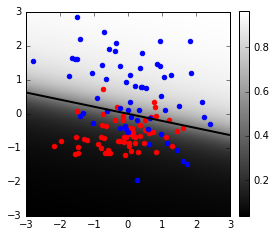

In [4]:
fig0, axes0 = plt.subplots(nrows=1, ncols=1,figsize=(4,4))
colors = ['r', 'g', 'b', 'm']

x = np.linspace(-3, 3, 500)
yy = np.linspace(-3, 3, 500).T
xx, yy = np.meshgrid(x, yy)
Xfull =  np.c_[xx.ravel(), yy.ravel()]
probas = 1.0/np.pi*np.arctan(np.dot(Xfull,res['x']))+0.5
Z = probas.reshape((500, 500))
   
axes0.scatter(XX[y==1,0],XX[y==1,1],color='r')
axes0.scatter(XX[y==0,0],XX[y==0,1],color='b')
#axes0.plot(x,-x*res['x'][0]/res['x'][1],color='k')
axes0.contour(xx,yy,Z,[0.5], linewidths=(2,), colors='k')
m = axes0.imshow( Z, extent=(-3, 3, -3, 3), origin='lower', cmap='gray')
cax,kw = mpl.colorbar.make_axes(axes0,fraction=0.046, pad=0.04)
plt.colorbar(m, cax=cax, ticks=np.arange(0,1,0.2), **kw);


In [5]:
#fig0.savefig('arctanClass.pdf', format='pdf', bbox_inches='tight')

# Example 6

In [6]:
# define helpers
def g(x,si):
    res = 1.0/(1.0-x**2)-2.0*np.log(si*np.ones(XX.shape[0]))
    return res
def dsi(mux,muy,si):
    R = np.linalg.norm(si*XX-np.array([[mux,muy]]), 2, axis=1)
    res = 2*np.einsum('i...,...i', XX.T, si*XX-np.array([[mux,muy]]))/(1.0-R**2)**2 - 2.0/(si*np.ones(XX.shape[0]))
    return res
def dmu(mux,muy,si):
    R = np.linalg.norm(si*XX-np.array([[mux,muy]]), 2, axis=1)
    R = R[:,np.newaxis]
    res = -2*(si*XX-np.array([[mux,muy]]))/(1.0-R**2)**2
    return res
def prob(x,y,si,mux,muy):
    R = (si*x-mux)**2+(si*y-muy)**2
    res = R
    res[R<=1] = np.exp(-1.0/(1.0-R[R<=1]))
    res[R>1] = 0
    return res

In [7]:
# define likelihood and likelihood gradient
options={'disp': True, 'maxiter': 3000, 'xtol': 1e-9,'return_all': False}  
def objfun(w):
    mu1x = w[0]
    mu1y = w[1]
    mu2x = w[2]
    mu2y = w[3]
    si1 = w[4]
    si2 = w[5]
    #SIG = np.array([si1*np.ones(XX.shape[0]),si2*np.ones(XX.shape[0])]).T
    S = np.array([g(np.linalg.norm(si1*XX-np.array([[mu1x,mu1y]]), 2, axis=1),si1),\
                  g(np.linalg.norm(si2*XX-np.array([[mu2x,mu2y]]), 2, axis=1),si2)]).T #+ 2*np.log(SIG)
    return np.einsum('i...,...i', S, yyy ).sum()
def objfunG(w):
    mu1x = w[0]
    mu1y = w[1]
    mu2x = w[2]
    mu2y = w[3]
    si1 = w[4]
    si2 = w[5]
    DSI = np.einsum('i...,...i', np.array([dsi(mu1x,mu1y,si1),dsi(mu2x,mu2y,si2)]).T, yyy)
    DMUX = np.einsum('i...,...i', np.array([dmu(mu1x,mu1y,si1)[:,0],dmu(mu2x,mu2y,si2)[:,0]]).T, yyy)
    DMUY = np.einsum('i...,...i', np.array([dmu(mu1x,mu1y,si1)[:,1],dmu(mu2x,mu2y,si2)[:,1]]).T, yyy)
    return np.array([DMUX[0],DMUY[0],DMUX[1],DMUY[1],DSI[0],DSI[1]])

# initialization
w0 = np.random.random(6)
w0[4:6] = w0[4:6]*0.1 
w0[0:2] = np.zeros(2)
w0[2:4] = np.zeros(2)

# optimize
res = opt.minimize(objfun, w0, method='Newton-CG', jac=objfunG, options=options) 
print res

Optimization terminated successfully.
         Current function value: 405.543666
         Iterations: 20
         Function evaluations: 26
         Gradient evaluations: 149
         Hessian evaluations: 0
  status: 0
 success: True
    njev: 149
    nfev: 26
     fun: 405.5436663269337
       x: array([-0.00666313,  0.17776336, -0.11752468, -0.27823597,  0.30202616,
        0.4586202 ])
 message: 'Optimization terminated successfully.'
    nhev: 0
     jac: array([  6.42104148e-08,  -3.76140349e-08,   1.98156869e-09,
        -5.84172710e-11,   5.09167653e-07,   6.68113103e-08])
     nit: 20


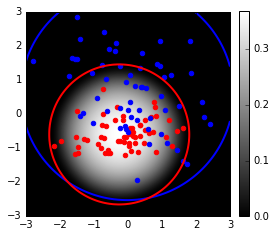

In [8]:
# display results
fig0, axes0 = plt.subplots(nrows=1, ncols=1,figsize=(4,4))
colors = ['r', 'g', 'b', 'm']

si1 = res['x'][4]
mu1x = res['x'][0]
mu1y = res['x'][1]
si2 = res['x'][5]
mu2x = res['x'][2]
mu2y = res['x'][3]

N = 500
xx = np.linspace(-3, 3, N)
yy = np.linspace(-3, 3, N).T
xx, yy = np.meshgrid(xx, yy)
Xfull =  np.c_[xx.ravel(), yy.ravel()]
probas1 = prob(xx,yy,si1,mu1x,mu1y)
probas2 = prob(xx,yy,si2,mu2x,mu2y)
Z1 = probas1.reshape((N, N))
Z2 = probas2.reshape((N, N))

axes0.scatter(XX[y==1,0],XX[y==1,1],color='r')
axes0.scatter(XX[y==0,0],XX[y==0,1],color='b')
axes0.contour(xx,yy,Z1,[0.0001], linewidths=(2,), colors='b')
axes0.contour(xx,yy,Z2,[0.0001], linewidths=(2,), colors='r')
m = axes0.imshow(Z2, extent=(-3, 3, -3, 3), origin='lower', cmap='gray')
cax,kw = mpl.colorbar.make_axes(axes0,fraction=0.046, pad=0.04)
plt.colorbar(m, cax=cax, ticks=np.arange(0,Z2.max(),0.1), **kw)

In [9]:
#fig0.savefig('cinfClassc.pdf', format='pdf', bbox_inches='tight')